# 1. Adjacent slices
Integration and alignment of adjacent slices from the BaristaSeq mouse visual cortex dataset

The BaristaSeq mouse visual cortex dataset consists of three tissue slices with similar domain distributions and morphological structures, containing 4,491, 3,545, and 3,390 spatial spots, respectively. We removed spots outside the ROIs in each slice’s detailed anatomical region annotations and selected Slices 1 and 2 for integration and alignment.

## Preparation

In [1]:
import sys
import time
from spatialFuser import *
import scanpy as sc
import pandas as pd
import numpy as np
sys.path.append("..")

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Hyper-Parameters setting
All hyperparameters are stored in the variable args. To display them during initialization, use the function call *args = def_training_args(show_detail=True)*.

As a low-throughput spatial transcriptomics dataset, BaristaSeq detects only 78 transcript features in total. Therefore, SpatialFuser employs two-layer MCGATE models with low latent dimension to learn data embeddings.

In [2]:
# load args:
print("============================================")
print("=              Setting Params              =")
slice_1_args = def_training_args()
slice_1_args.hidden = [64, 32]
slice_1_args.epoch = 500
slice_1_args.lr = 5e-3
slice_1_args.K = 12
slice_1_args.alpha = 0

slice_2_args = def_training_args()
slice_2_args.hidden = [64, 32]
slice_2_args.epoch = 500
slice_2_args.lr = 5e-3
slice_2_args.K = 12
slice_2_args.alpha = 0

integration_args = def_training_args()
integration_args.hidden = [32, 32]
integration_args.fusion_epoch = 500
integration_args.lr = 1e-6
integration_args.match_step_size = 20
integration_args.tau = 0.1
integration_args.roi_radius = 0.02
integration_args.match_threshold = 0
integration_args.epsilon = 1
integration_args.m_top_K = 4
integration_args.beta_rec = 1
integration_args.beta_dir = 0

=              Setting Params              =


## Load data
SpatialFuser provides a built-in data loading and preprocessing module, *SpatialFuserDataLoader*. The required inputs include hyperparameters, data_dir (the dataset storage directory), data_tech (either “seq-based” or “image-based”), and files (a list of h5ad files to be loaded).

For spatial omics data, *SpatialFuserDataLoader* constructs a KNN adjacency graph based on the specified value of K to support graph neural network training.

For seq-based data, spatially variable genes are extracted according to n_svgs to simplify the model.

All AnnData objects are normalized, log-transformed, and subsequently converted into PyG objects for model input.

In [3]:
# load data:
print("============================================")
print("=               Loading Data               =")
slice_1_dataLoader = SpatialFuserDataLoader(slice_1_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/BARISTASeq_mouse_VisCortex',
                                            data_tech='image-based',
                                            files=['ROI_Slice_1.h5ad'])
slice_1_dataLoader.load_adata()
slice_1_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_2_args.K, batch_label=[1])
slice_1_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

slice_2_dataLoader = SpatialFuserDataLoader(slice_2_args,
                                            data_dir='/public8/lilab/student/whcai/Integration/data/BARISTASeq_mouse_VisCortex',
                                            data_tech='image-based',
                                            files=['ROI_Slice_2.h5ad'])
slice_2_dataLoader.load_adata()
slice_2_dataLoader.pre_processing(n_svgs=3000, k_cutoff=slice_2_args.K, batch_label=[2])
slice_2_dataLoader.generate_minibatch(loader_type='RandomNodeLoader', num_workers=5)

=               Loading Data               =
=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 19825 edges, 1525 cells=
=   13.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 1525 nodes           =
=   12.0000 neighbors per cell on average   =
batch:[1.], node num:[1525]
=         Calculating spatial graph        =
The PyG data u create is qualified
=The graph contains 26546 edges, 2042 cells=
=   13.0000 neighbors per cell on average   =
=              subgraph Info             =
=           Batch 0: 2042 nodes           =
=   12.0000 neighbors per cell on average   =
batch:[2.], node num:[2042]


## Train

The MCGATEs are first pre-trained individually, after which the fusion layer and matching layer are incorporated into the training process.

In [4]:
# train
print("============================================")
print("=              Begin to Train              =")
training_time = time.time()
[adata1, adata2], trainer = train_integration([slice_1_args, slice_2_args, integration_args],
                                              [slice_1_dataLoader, slice_2_dataLoader])
print("=            Training Finished!            =")
print("Total time elapsed: {:.4f}s".format(time.time() - training_time))
print("============================================")

=              Begin to Train              =


/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:137: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  self.adata1_adata2atial_adj = torch.sparse.FloatTensor(batch_in_data1.edge_index,
Epoch 500 || adata1_pretrain_loss: 3.2141 || adata2_pretrain_loss: 3.2727 || : 100%|██| 500/500 [00:30<00:00, 16.40it/s]
Epoch 500 || Fusion_loss : 0.3208 || MSE_loss: 6.7447 || Dir_loss: 0.5585 || : 100%|██| 500/500 [00:32<00:00, 15.62it/s]
/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatialFuser/train.py:419: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  dataLoader_list[0].adata.uns['adata1_embedding_loss_list'] = trainer.adata1_embedding_loss_list
/public8/lilab/student/whcai/Integration/model/SpatialFuser/spatia

=            Training Finished!            =
Total time elapsed: 63.0844s


## Spatial domain detection after integration
SpatialFuser provides an evaluation module, *metrics*, for assessing tissue domain detection tasks. It treats the Region column in anndata.obs as the ground truth and, based on the provided embed_label (an array stored in anndata.obsm), automatically computes five metrics (ARI, AMI, Homogeneity, Completeness, and V-Measure) under clustering methods including Leiden, Louvain, and Mclust.

Here, we only present the spatial domains and Umap colored by Mclust.

2025-08-25 19:58:49.254782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 19:58:49.461984: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 19:58:51.074844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/cv2/../../lib64::/usr/local/

fitting ...
  |======================================================================| 100%


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


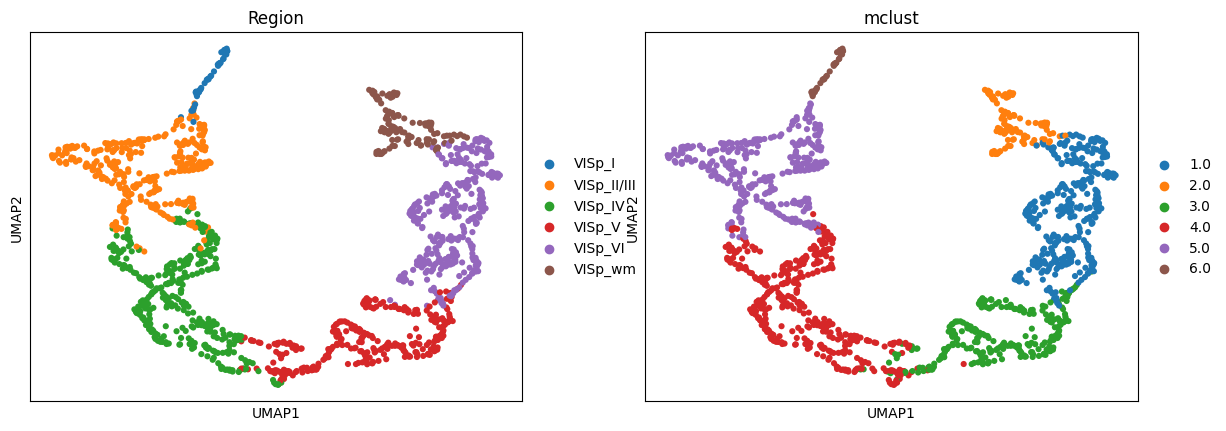

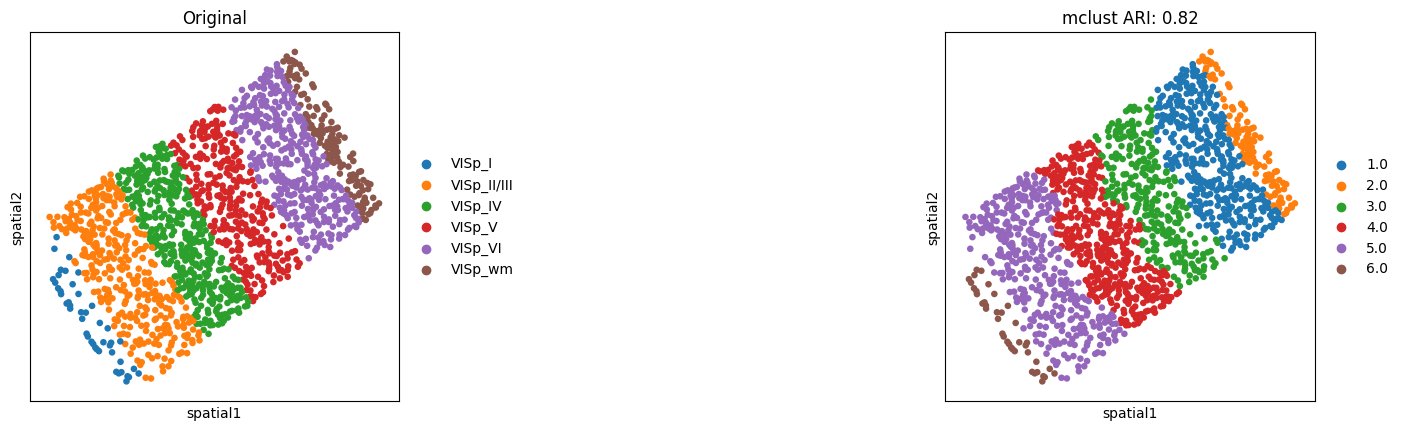

fitting ...
  |======================================================================| 100%


/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


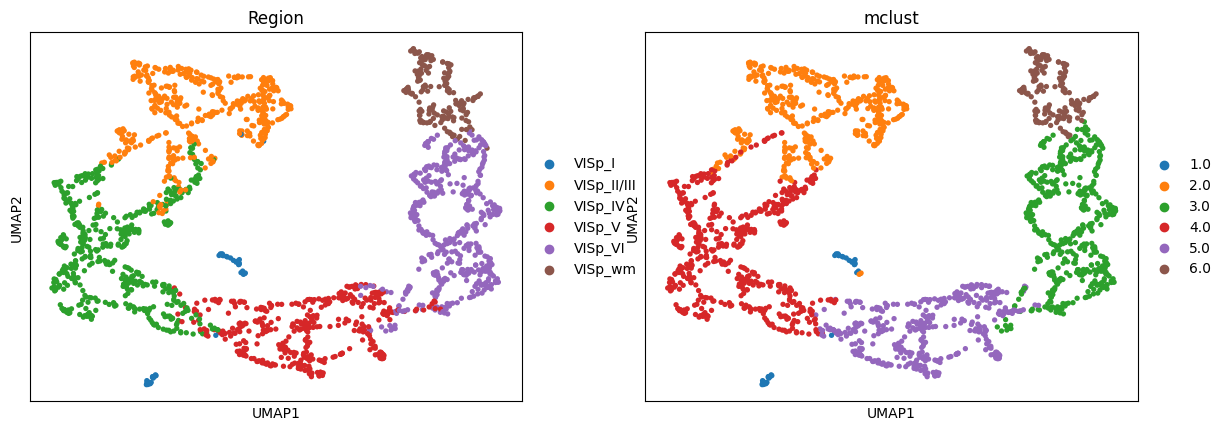

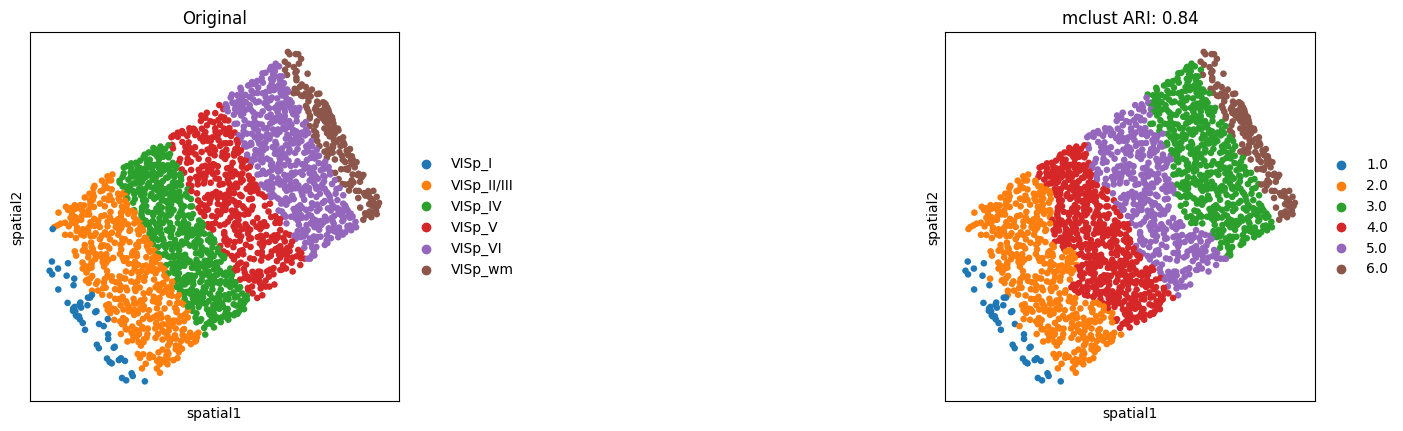

In [5]:
# evaluate and plot
# spatial domain detection
adata1_leiden_result, adata1_louvain_result, adata1_mclust_result = metrics(adata1,
                                                                            save_loc='_BaristaSeq_slice1.png',
                                                                            resolution=0.1,
                                                                            spot_size=0.02,
                                                                            cluster_label='Region',
                                                                            plot_color=["mclust"],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=True,
                                                                            save=False)

adata2_leiden_result, adata2_louvain_result, adata2_mclust_result = metrics(adata2,
                                                                            save_loc='_BaristaSeq_slice2.png',
                                                                            resolution=0.1,
                                                                            spot_size=0.02,
                                                                            cluster_label='Region',
                                                                            plot_color=["mclust"],
                                                                            mclust_model='EEE',
                                                                            embed_label='fused_embedding',
                                                                            vis=True,
                                                                            save=False)

## Batch effect correction

UMAP visualizations colored by ground truth annotation (left) and batches (right), illustrating that the model preserves true biological differences while achieving effective integration.

/home/whcai/anaconda3/envs/PyG/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


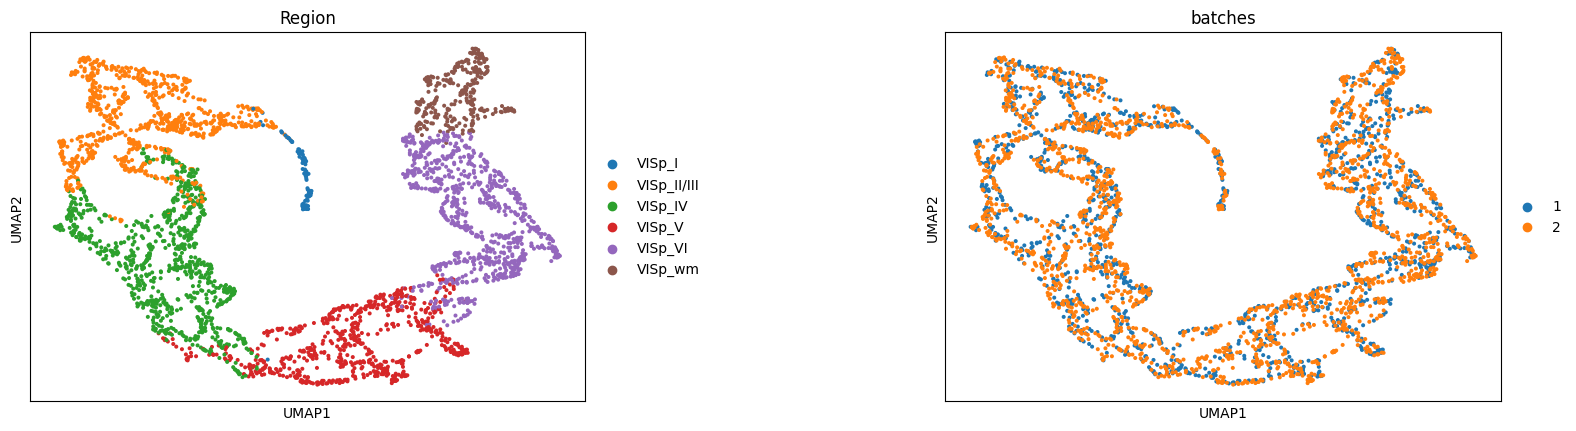

In [6]:
# batch effect correction (integration)
checkBatch(adata1, adata2, save=None)

## Show alignment

Alignment of slices 1 and 2 from the BaristaSeq mouse visual cortex dataset, colored by region labels (300 alignment pairs shown for clarity)

dataset1: 6 cell types; dataset2: 6 cell types; 
                    Total :6 celltypes; Overlap: 6 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 1821


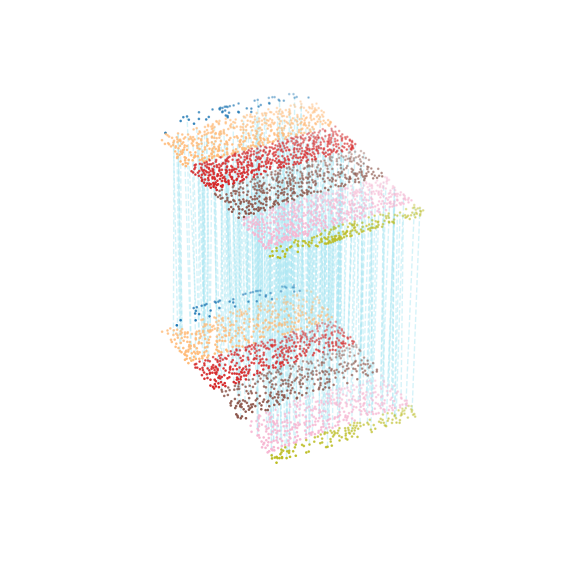

In [7]:
# show alignment
adata1_df = pd.DataFrame({'index': range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:, 0],
                          'y': adata1.obsm['spatial'][:, 1],
                          'celltype': adata1.obs['Region']})
adata2_df = pd.DataFrame({'index': range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:, 0],
                          'y': adata2.obsm['spatial'][:, 1],
                          'celltype': adata2.obs['Region']})
matching = np.array([trainer.match_in_adata1.data.cpu().numpy(), trainer.match_in_adata2.data.cpu().numpy()])
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)
multi_align.draw_3D(target='all_type', size=[7, 8], line_width=1, point_size=[0.8, 0.8], line_color='blue',
                    hide_axis=True, show_error=False, only_show_correct=True, only_show_error=False,
                    line_alpha=0.5)

## Spots mapping accuracy
The all_matching function returns two plots:
1. A Sankey plot illustrating spots type correspondence based on alignments from SpatialFuser.
2. A histogram showing the similarity score distributions from random matching (bottom) and SpatialFuser matching (top) in pairwise alignments.


QC threshold：0.95%  -> 0.9218
valid matching ratio：99.4% (1516/1525)
spots mapping acc：97.23% (1474/1516)


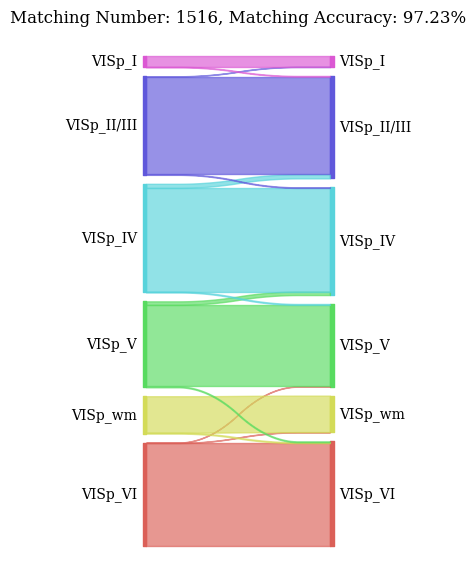

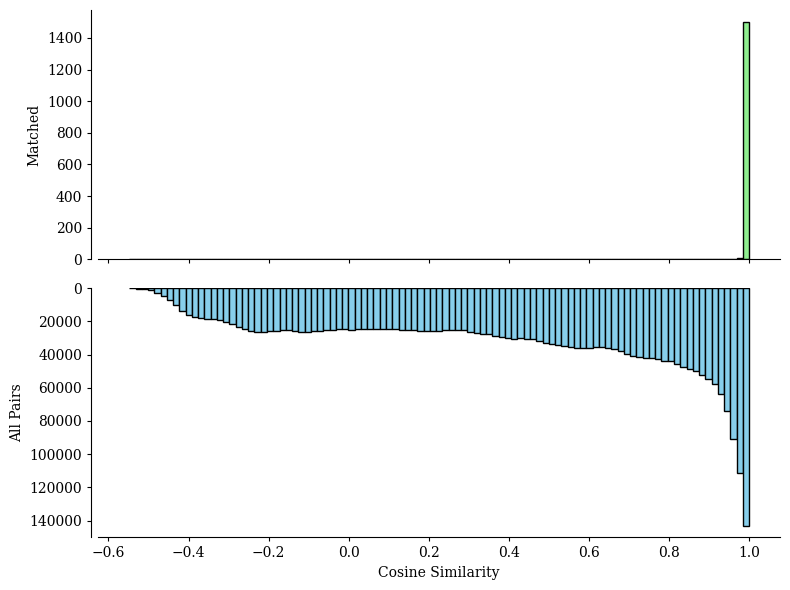

(0.9940983606557378, 0.9722955145118733)

In [8]:
# evaluate alignment
all_matching(adata1, adata2, 0.95, 0.025, save_loc=None, file_name=None)